## Audio Data loaing and exploration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import Necessary Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import math
import tensorflow as tf
from tensorflow import keras
import warnings
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Activation, Multiply, Permute, RepeatVector, Flatten
from keras import backend
import matplotlib.pyplot as plt
import librosa #Python package for music & audio files
import librosa.display


In [ ]:
# print classifications
base_path='/content/drive/MyDrive/Colab Notebooks/Music DataSet/Data'
genres=os.listdir(os.path.join(base_path,'genres_original/'))
print(genres)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [ ]:
num_classes = 10 #number of classifications

In [ ]:
# Loading and Displaying Audio Data, Create functions to load audio files and display their waveforms and spectrograms
def load_audio(file_path):
    audio, sr = librosa.load(file_path)
    return audio, sr

def display_waveform(audio, sr, title):
    plt.figure(figsize=(8, 2))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(title)
    plt.show()

def display_spectrogram(y, sr, title):
    S = librosa.feature.melspectrogram(y=audio, sr=sr)
    S_DB = librosa.amplitude_to_db(S, ref=np.max)
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='log', cmap='cool')
    plt.colorbar()
    plt.title(title)
    plt.show()


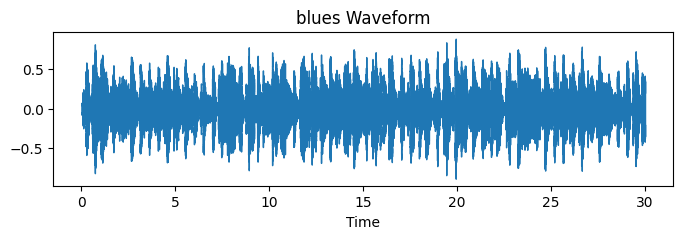

In [ ]:
# Example usage
blues, sr = load_audio(os.path.join(base_path,'genres_original/blues/blues.00000.wav'))
display_waveform(blues, sr, "blues Waveform")

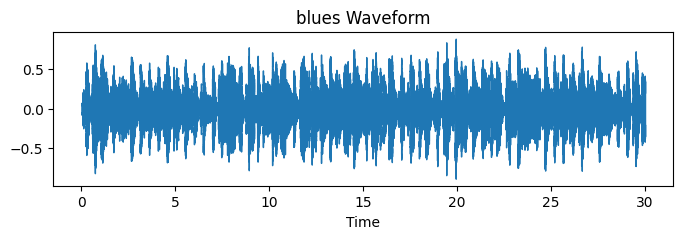

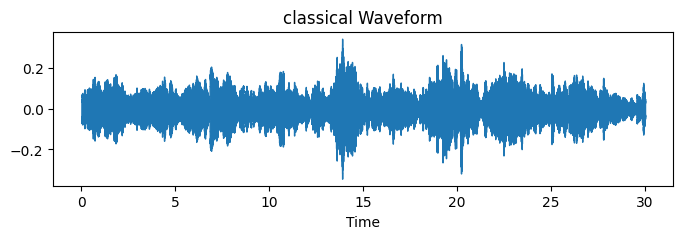

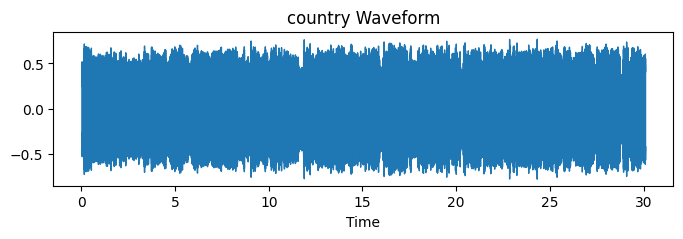

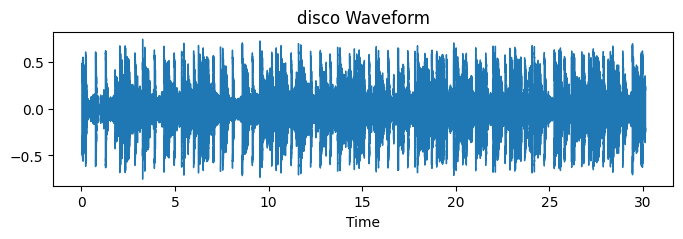

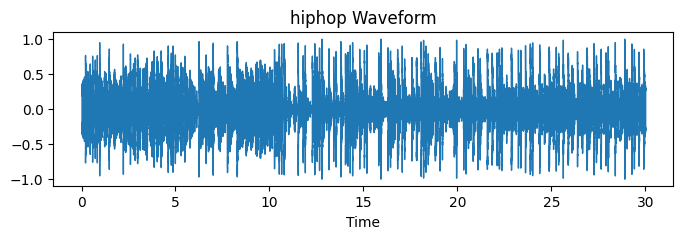

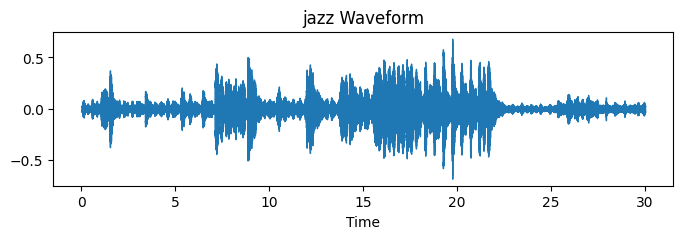

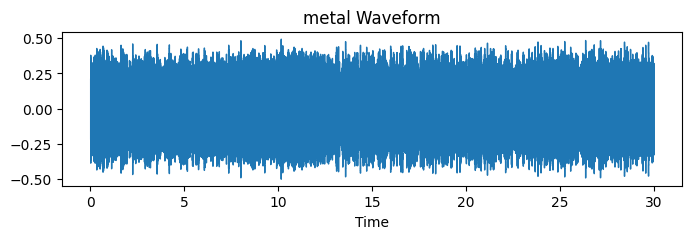

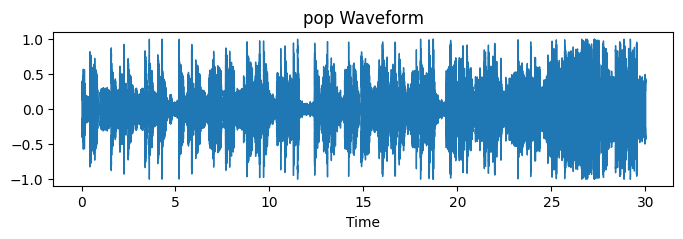

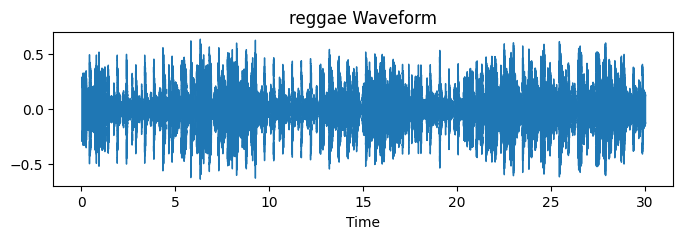

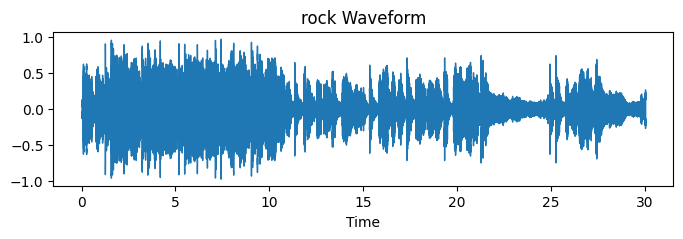

In [ ]:
# show the waveform
for i in genres:
    audio, sr=load_audio(os.path.join(base_path,'genres_original',i,f'{i}.00000.wav'))
    display_waveform(audio, sr, f'{i}' " Waveform")

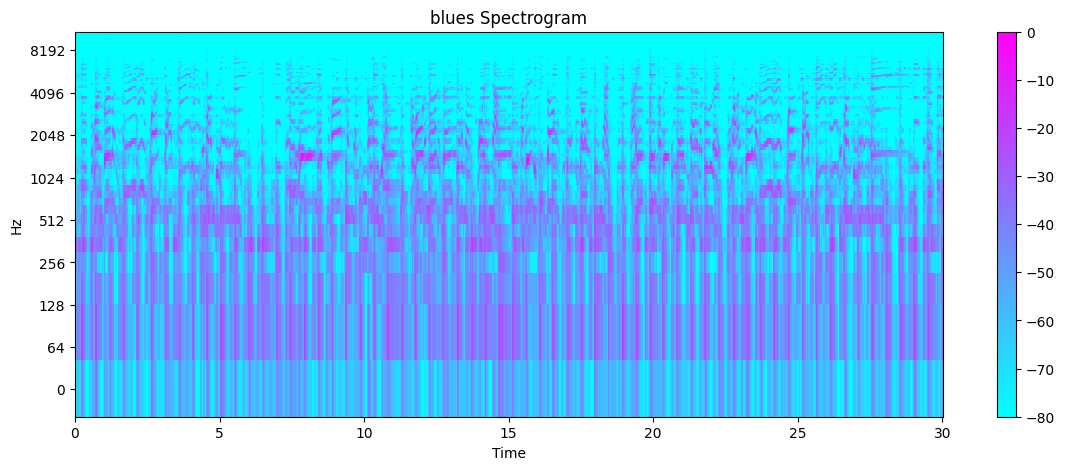

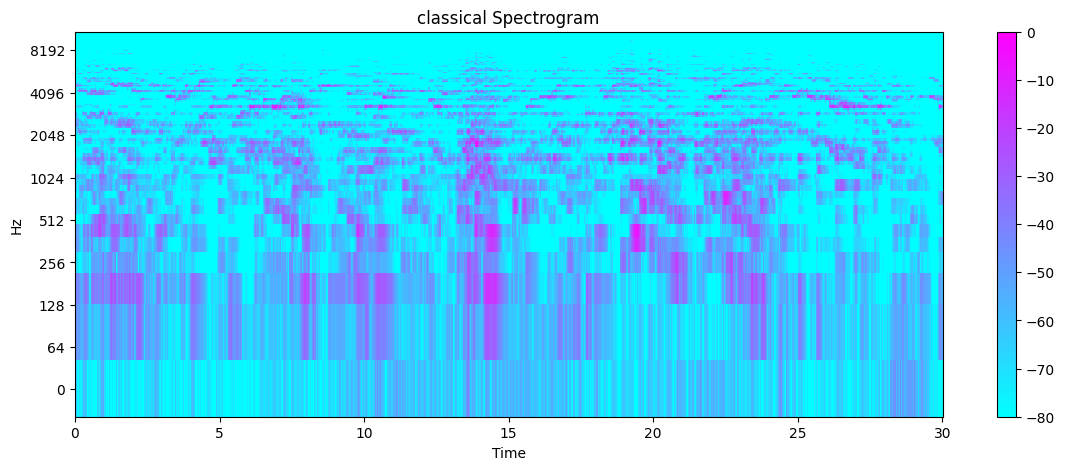

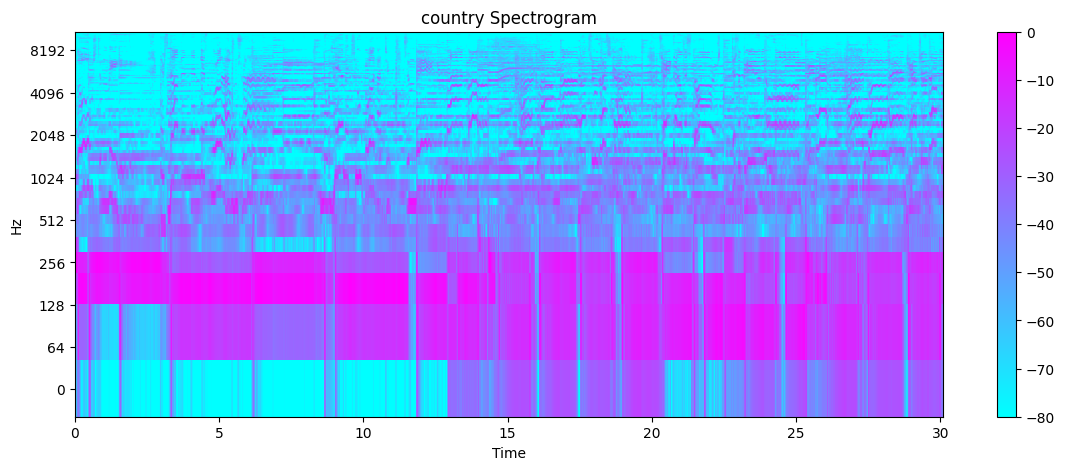

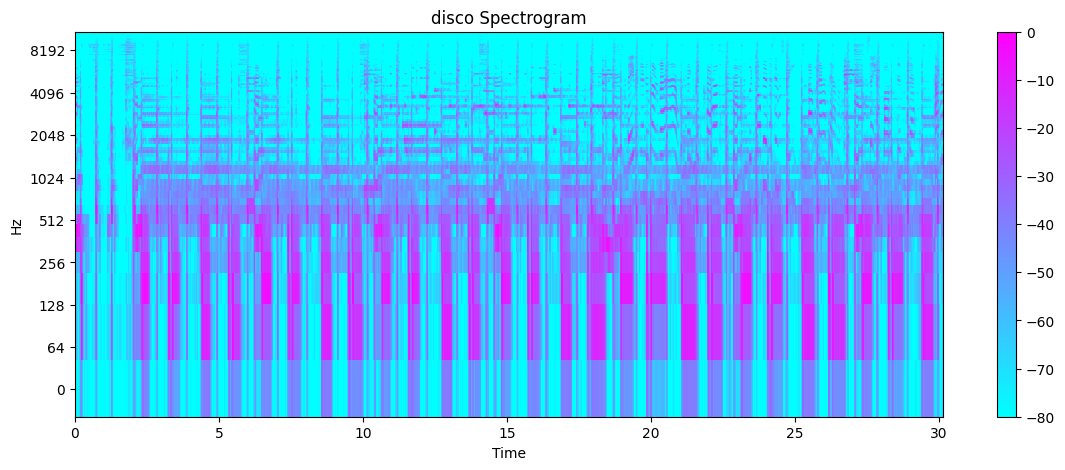

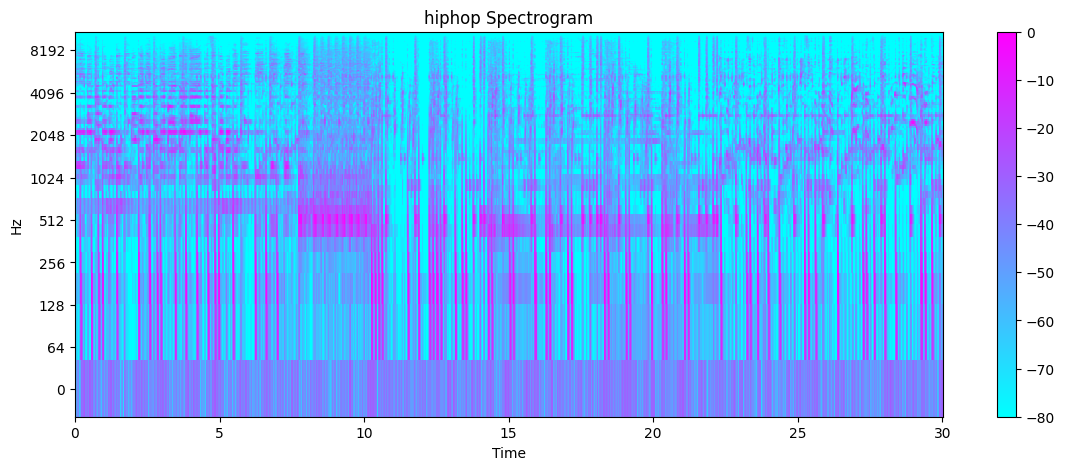

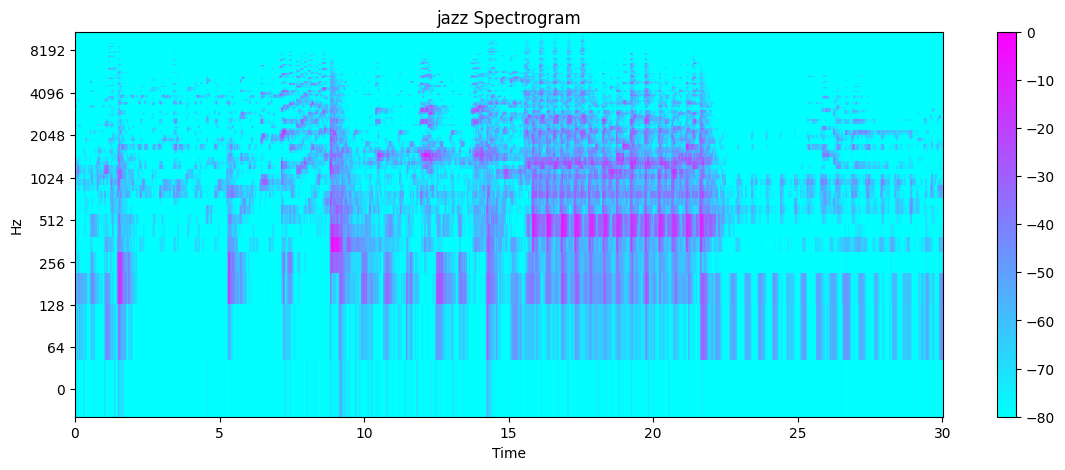

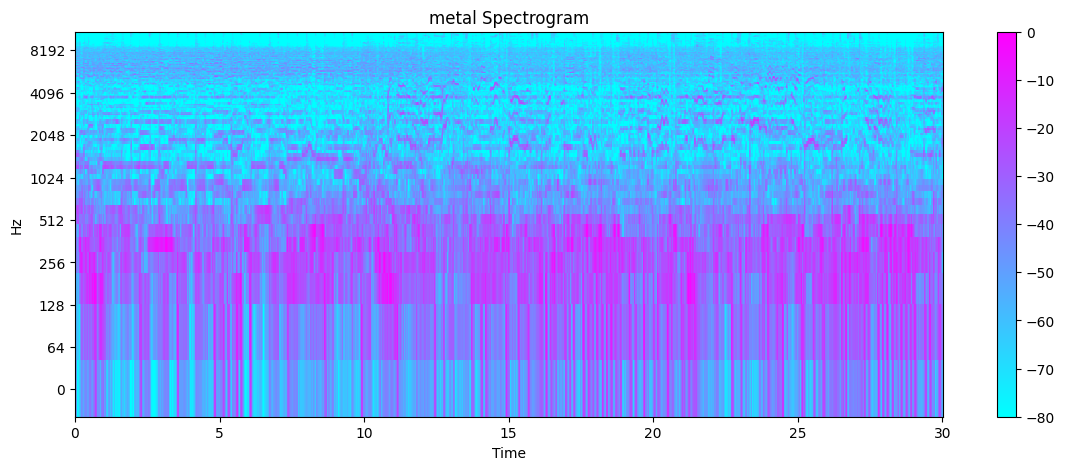

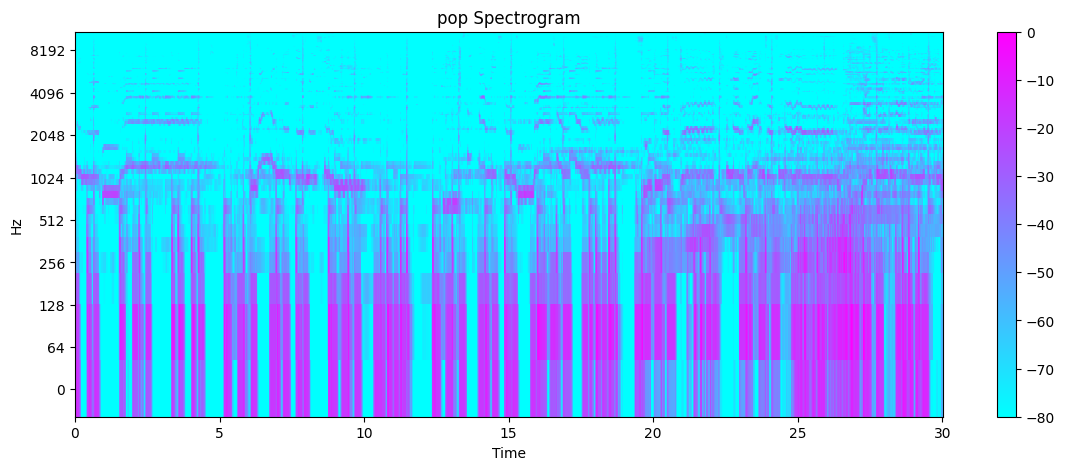

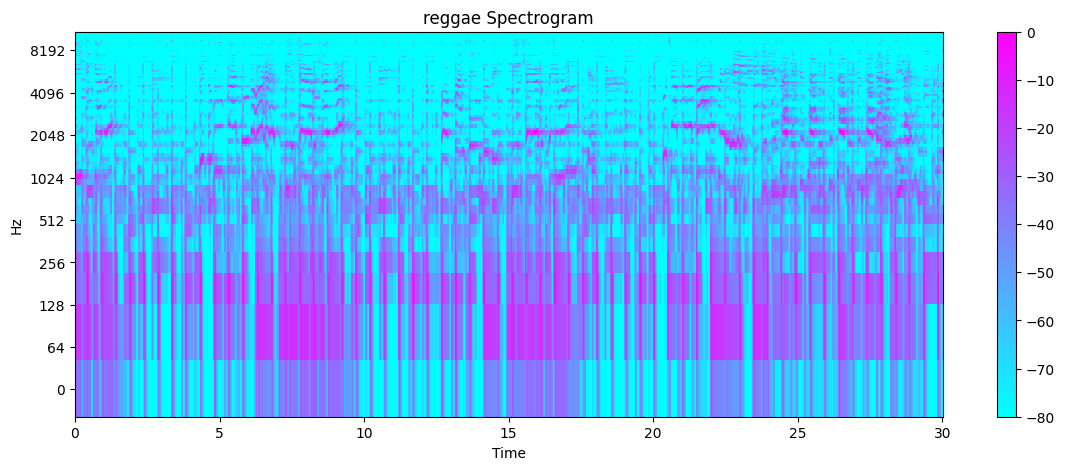

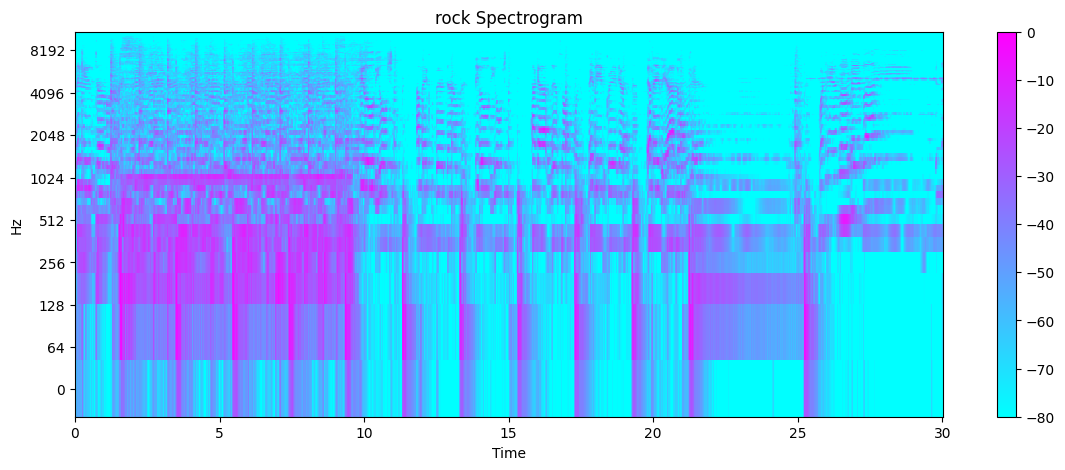

In [ ]:
# show the spectrogram
for i in genres:
    audio, sr=load_audio(os.path.join(base_path,'genres_original',i,f'{i}.00000.wav'))
    display_spectrogram(audio, sr, f'{i}' " Spectrogram")

In [ ]:
# define The Mel frequency cepstral coefficients (MFCCs)
def display_mfccs(audio, sr, title):
    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

    # Compute the mean of MFCCs across time (axis 1)
    mfccs_mean = np.mean(mfccs, axis=1)

    # Plotting
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()


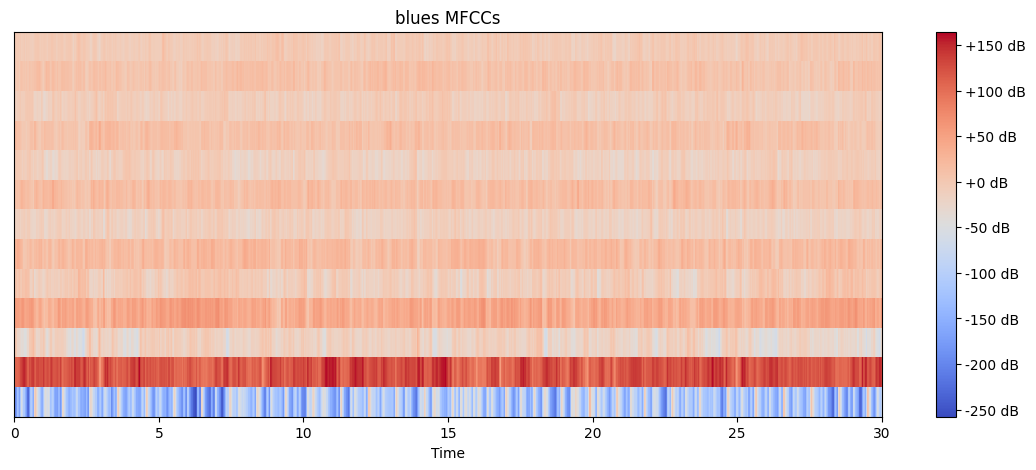

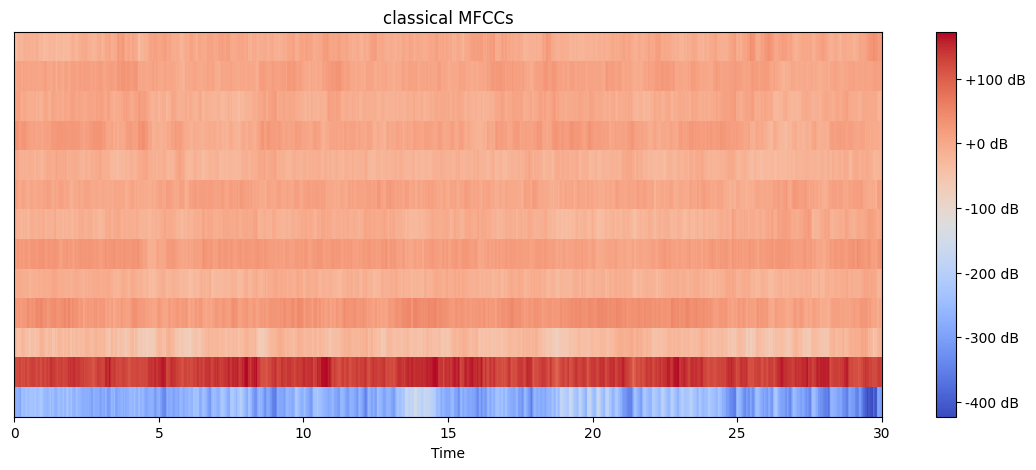

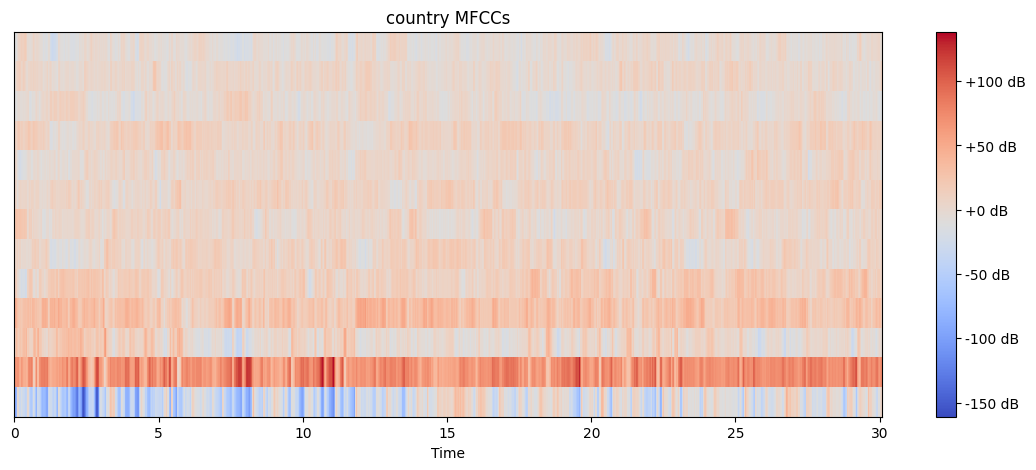

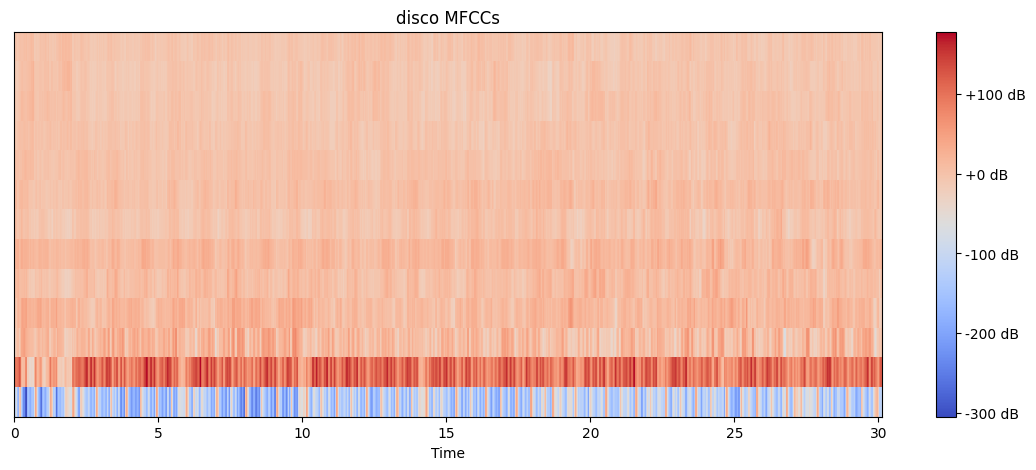

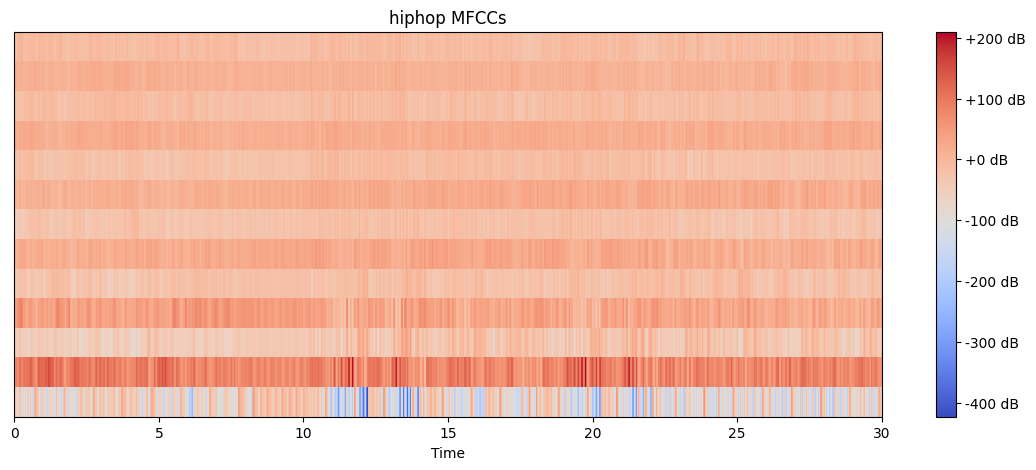

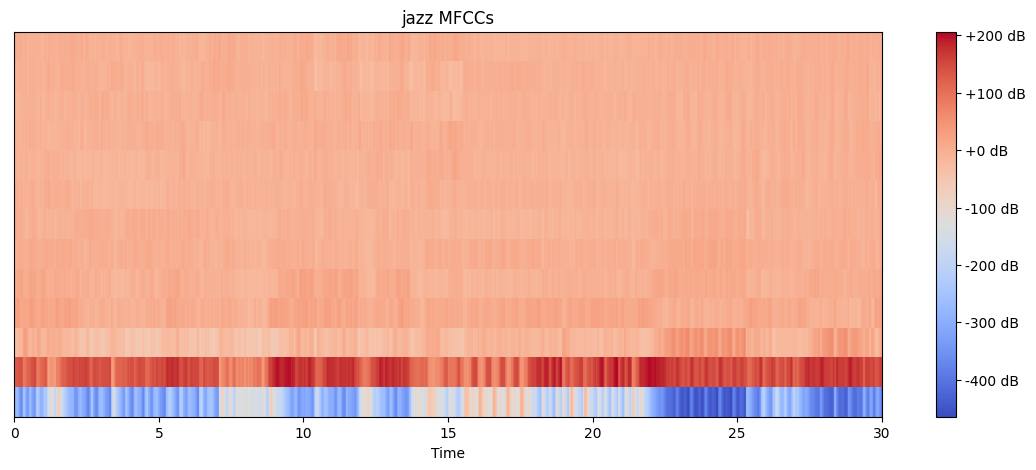

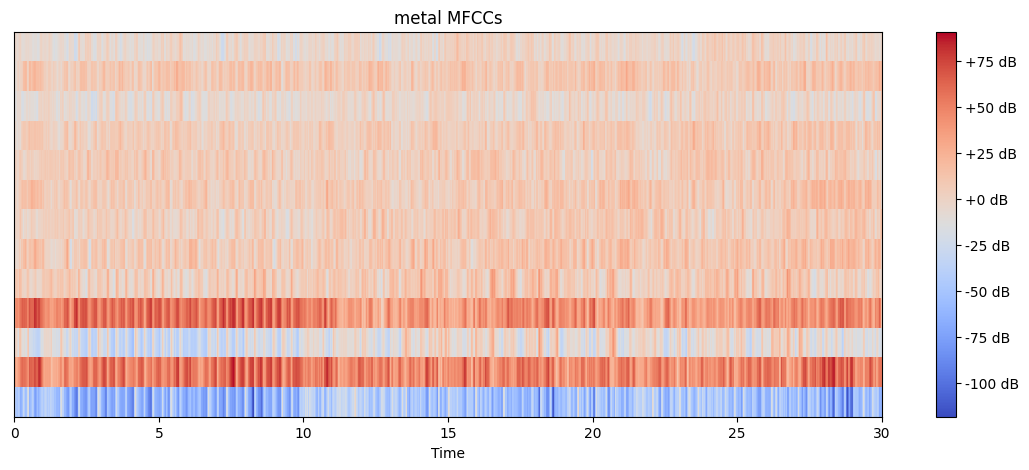

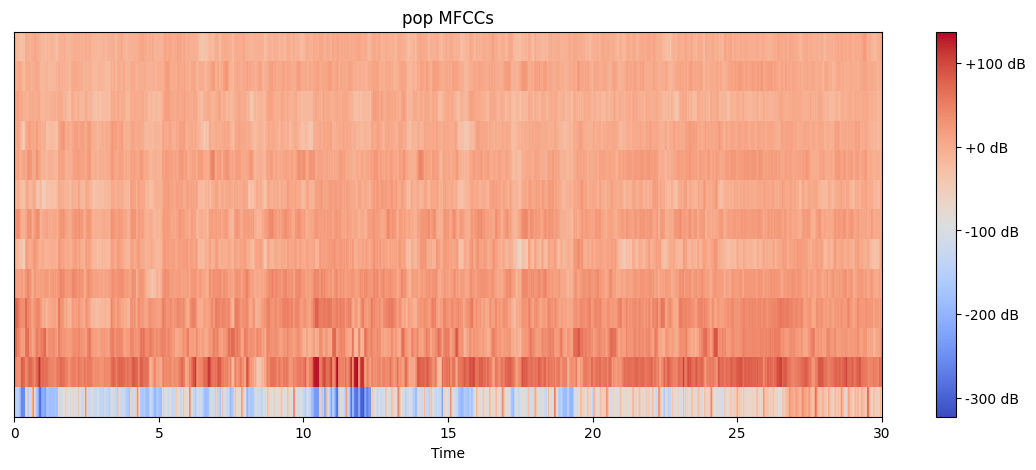

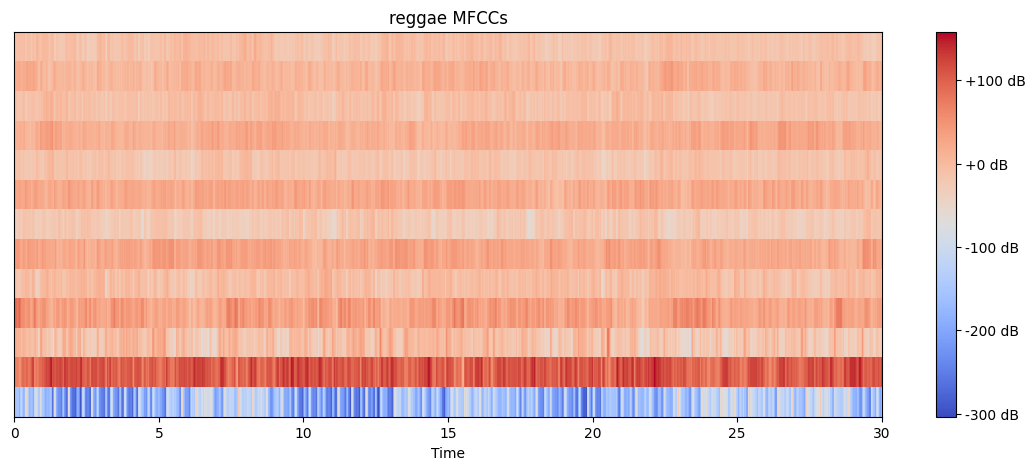

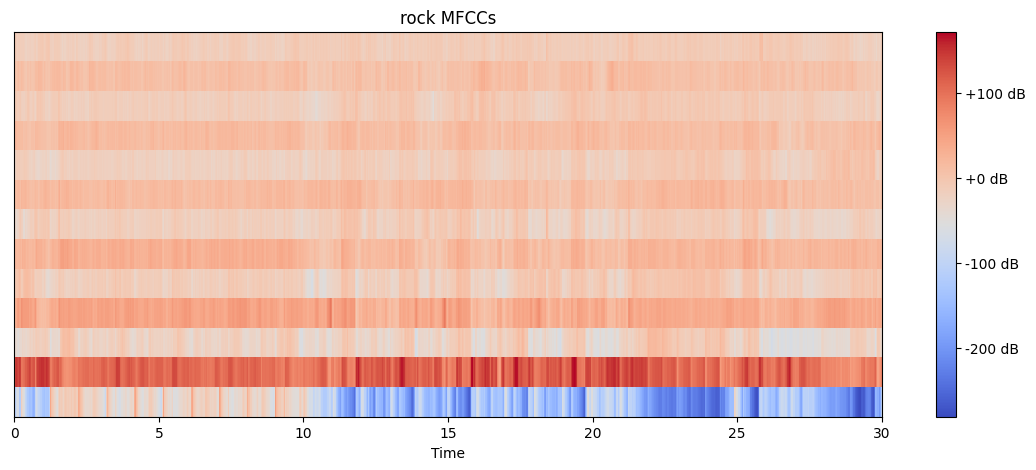

In [ ]:
# show the mfccs
for i in genres:
    audio, sr=load_audio(os.path.join(base_path,'genres_original',i,f'{i}.00000.wav'))
    display_mfccs(audio, sr, f'{i}' " MFCCs")

In [ ]:
#use the 3 seconds CSV file to predict the Genre of the audio
music_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Music DataSet/Data/features_split.csv')
music_data= music_data.iloc[0:, 1:]
music_data.head(5)

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
y = music_data['label']# genre variable.
X = music_data.loc[:, music_data.columns != 'label']
print(X)

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              19

In [ ]:
# Normalize so everything is on the same scale.
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit and transform the scaler on the data
X = scaler.fit_transform(X)
print(X)

[[ 0.         -0.48780784  0.64052047 ... -0.51356204  0.12841417
  -0.29178072]
 [ 0.         -0.40314187  0.13183473 ...  1.01138445  1.27578001
   0.05642464]
 [ 0.         -0.36169428  0.7644909  ... -0.04624405  0.65390663
  -0.52145798]
 ...
 [ 0.         -0.35433044  0.42997426 ... -0.15370124  0.11765485
  -0.33882395]
 [ 0.          0.0883611  -0.00630133 ... -0.72456977  0.30333409
  -0.95893743]
 [ 0.         -0.11321002  0.19536324 ... -0.37245283 -0.47495901
  -0.55112155]]


In [ ]:
# Normalize so everything is on the same scale.
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the data
X = scaler.fit_transform(X)

# Reshape X_scaled for CNN input
X = X.reshape(X.shape[0], X.shape[1], 1)
print(X)
fit = StandardScaler()
X = fit.fit_transform(np.array(music_data.iloc[:, :-1], dtype = float))
print(X)

[[[ 0.        ]
  [-0.48780784]
  [ 0.64052047]
  ...
  [-0.51356204]
  [ 0.12841417]
  [-0.29178072]]

 [[ 0.        ]
  [-0.40314187]
  [ 0.13183473]
  ...
  [ 1.01138445]
  [ 1.27578001]
  [ 0.05642464]]

 [[ 0.        ]
  [-0.36169428]
  [ 0.7644909 ]
  ...
  [-0.04624405]
  [ 0.65390663]
  [-0.52145798]]

 ...

 [[ 0.        ]
  [-0.35433044]
  [ 0.42997426]
  ...
  [-0.15370124]
  [ 0.11765485]
  [-0.33882395]]

 [[ 0.        ]
  [ 0.0883611 ]
  [-0.00630133]
  ...
  [-0.72456977]
  [ 0.30333409]
  [-0.95893743]]

 [[ 0.        ]
  [-0.11321002]
  [ 0.19536324]
  ...
  [-0.37245283]
  [-0.47495901]
  [-0.55112155]]]
[[ 0.         -0.48780784  0.64052047 ... -0.51356204  0.12841417
  -0.29178072]
 [ 0.         -0.40314187  0.13183473 ...  1.01138445  1.27578001
   0.05642464]
 [ 0.         -0.36169428  0.7644909  ... -0.04624405  0.65390663
  -0.52145798]
 ...
 [ 0.         -0.35433044  0.42997426 ... -0.15370124  0.11765485
  -0.33882395]
 [ 0.          0.0883611  -0.00630133 ...

In [ ]:
input_shape = (58,1)
print(input_shape[0],)

58


In [ ]:
# Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Data type:", X_train.dtype)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

X_train shape: (6993, 58)
X_test shape: (2997, 58)
Data type: float64
y_train shape: (6993,)
y_test shape: (2997,)


In [ ]:
input_shape=(X_train.shape[1],1)
print(input_shape)

(58, 1)


In [ ]:
# Model Building (CNN model)

model = keras.Sequential([
    keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(128, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 56, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 28, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 13, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 128)           24704     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 5, 128)            0

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
print(y_train)


[5 3 9 ... 5 0 7]


In [ ]:
# Train the model
# Define the number of epochs and batch size
epochs = 100
batch_size = 32

# Train the model
history_cnn1 = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))


Epoch 1/100
219/219 [==============================] - 2s 7ms/step - loss: 1.5234 - accuracy: 0.4464 - val_loss: 1.2118 - val_accuracy: 0.5822
Epoch 2/100
219/219 [==============================] - 1s 7ms/step - loss: 1.0386 - accuracy: 0.6386 - val_loss: 0.9498 - val_accuracy: 0.6763
Epoch 3/100
219/219 [==============================] - 2s 9ms/step - loss: 0.8123 - accuracy: 0.7201 - val_loss: 0.8287 - val_accuracy: 0.7341
Epoch 4/100
219/219 [==============================] - 2s 10ms/step - loss: 0.6532 - accuracy: 0.7755 - val_loss: 0.7587 - val_accuracy: 0.7518
Epoch 5/100
219/219 [==============================] - 2s 7ms/step - loss: 0.5165 - accuracy: 0.8270 - val_loss: 0.6607 - val_accuracy: 0.7905
Epoch 6/100
219/219 [==============================] - 1s 7ms/step - loss: 0.4333 - accuracy: 0.8521 - val_loss: 0.6300 - val_accuracy: 0.7948
Epoch 7/100
219/219 [==============================] - 1s 6ms/step - loss: 0.3475 - accuracy: 0.8813 - val_loss: 0.6143 - val_accuracy: 0.811

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


94/94 [==============================] - 1s 5ms/step - loss: 0.3829 - accuracy: 0.8972
Test Loss: 0.3829011023044586
Test Accuracy: 0.8972305655479431


<ipython-input-26-fdb70c2671e9>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'r-', label='Training loss', color='red')  # Red for training loss
<ipython-input-26-fdb70c2671e9>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b-', label='Validation loss', color='blue')  # Blue for validation loss
<ipython-input-26-fdb70c2671e9>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'g-', label='Training acc', color='green')  # Green for training accuracy
<ipython-input-26-fdb70c2671e9>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "m

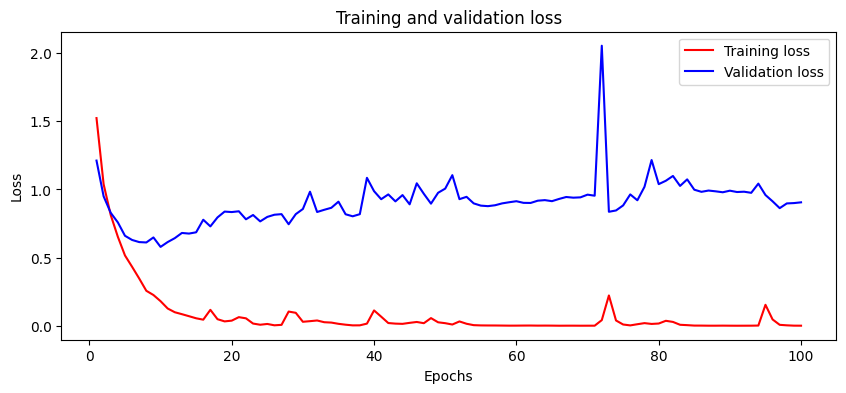

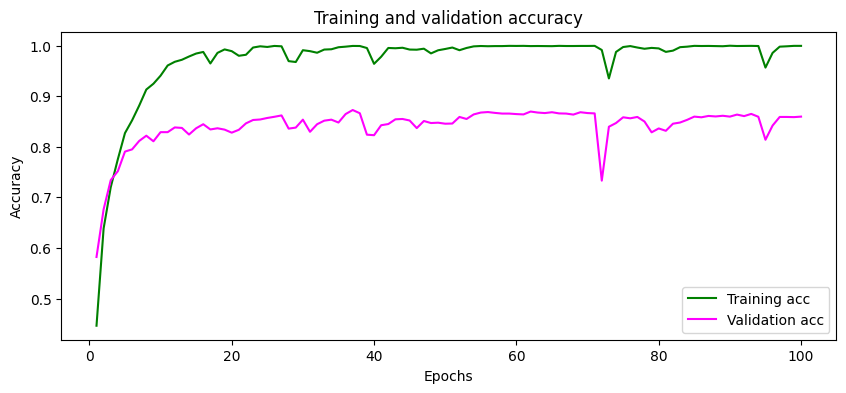

In [ ]:
# Plot the training and validation accuracy and loss at each epoch
loss = history_cnn1.history['loss']
val_loss = history_cnn1.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, loss, 'r-', label='Training loss', color='red')  # Red for training loss
plt.plot(epochs, val_loss, 'b-', label='Validation loss', color='blue')  # Blue for validation loss
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 4))
acc = history_cnn1.history['accuracy']
val_acc = history_cnn1.history['val_accuracy']
plt.plot(epochs, acc, 'g-', label='Training acc', color='green')  # Green for training accuracy
plt.plot(epochs, val_acc, 'm-', label='Validation acc', color='magenta')  # Magenta for validation accuracy
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



## Add dropout layer have a better performance

Epoch 1/100
219/219 [==============================] - 3s 9ms/step - loss: 1.8936 - accuracy: 0.3017 - val_loss: 1.5491 - val_accuracy: 0.4618
Epoch 2/100
219/219 [==============================] - 2s 8ms/step - loss: 1.5409 - accuracy: 0.4422 - val_loss: 1.3137 - val_accuracy: 0.5372
Epoch 3/100
219/219 [==============================] - 2s 8ms/step - loss: 1.3802 - accuracy: 0.4996 - val_loss: 1.2269 - val_accuracy: 0.5796
Epoch 4/100
219/219 [==============================] - 2s 8ms/step - loss: 1.2659 - accuracy: 0.5431 - val_loss: 1.0386 - val_accuracy: 0.6520
Epoch 5/100
219/219 [==============================] - 2s 7ms/step - loss: 1.2044 - accuracy: 0.5779 - val_loss: 1.0193 - val_accuracy: 0.6456
Epoch 6/100
219/219 [==============================] - 2s 10ms/step - loss: 1.1244 - accuracy: 0.6088 - val_loss: 0.9347 - val_accuracy: 0.6867
Epoch 7/100
219/219 [==============================] - 2s 11ms/step - loss: 1.0860 - accuracy: 0.6185 - val_loss: 0.9047 - val_accuracy: 0.69

<ipython-input-27-41dde5206b13>:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'r-', label='Training loss', color='red')  # Red for training loss
<ipython-input-27-41dde5206b13>:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b-', label='Validation loss', color='blue')  # Blue for validation loss
<ipython-input-27-41dde5206b13>:53: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'g-', label='Training acc', color='green')  # Green for training accuracy
<ipython-input-27-41dde5206b13>:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string 

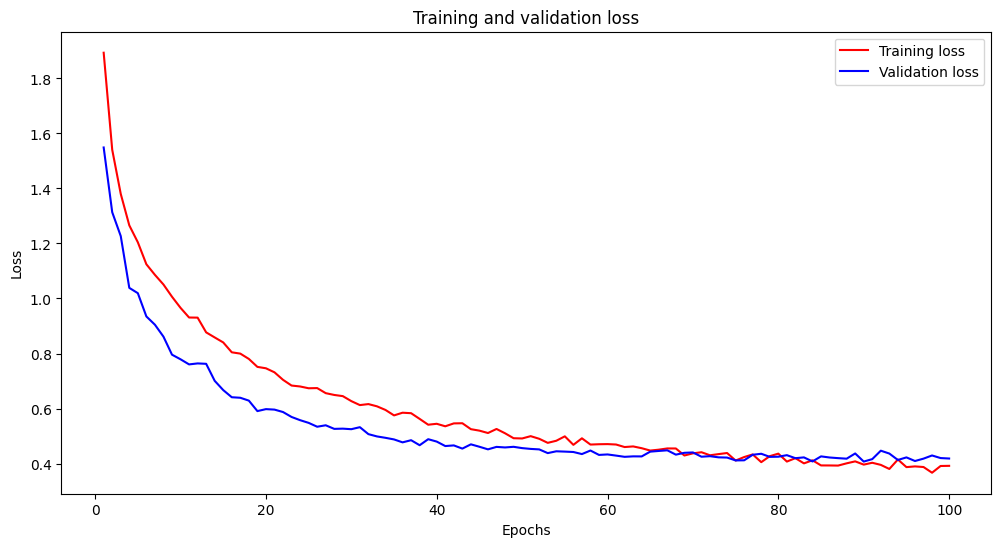

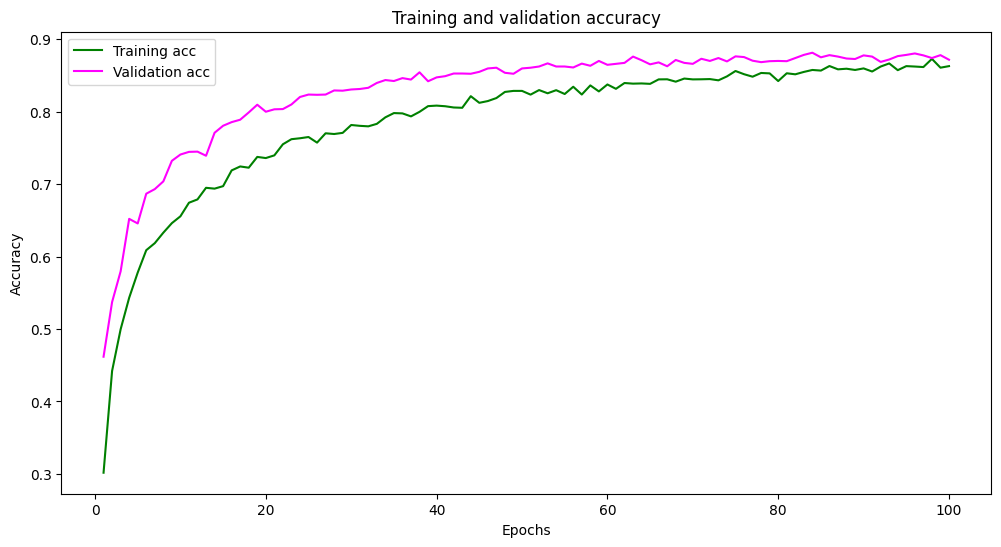

In [ ]:
# Model Building (CNN model 2)---add dropout

model = keras.Sequential([
    keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Dropout(0.25),  # Dropout layer after MaxPooling

    keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Dropout(0.25),  # Dropout layer

    keras.layers.Conv1D(128, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Dropout(0.25),  # Dropout layer

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),  # Dropout layer before the final Dense layer

    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

epochs = 100
batch_size = 32

# Train the model
history_cnn2 = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
# Plot the training and validation accuracy and loss at each epoch
loss = history_cnn2.history['loss']
val_loss = history_cnn2.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'r-', label='Training loss', color='red')  # Red for training loss
plt.plot(epochs, val_loss, 'b-', label='Validation loss', color='blue')  # Blue for validation loss
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 6))
acc = history_cnn2.history['accuracy']
val_acc = history_cnn2.history['val_accuracy']
plt.plot(epochs, acc, 'g-', label='Training acc', color='green')  # Green for training accuracy
plt.plot(epochs, val_acc, 'm-', label='Validation acc', color='magenta')  # Magenta for validation accuracy
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



### Using LSTM to build the model

In [ ]:
print("X_train shape:", X_train.shape)
len(X_train.shape)


X_train shape: (6993, 58)


2

In [ ]:
X_train = np.expand_dims(X_train, axis=2)
input_shape = (X_train.shape[1], X_train.shape[2])
print("Input shape for LSTM:", input_shape)

Input shape for LSTM: (58, 1)


In [ ]:
# Model Building (LSTM model)

# Define the LSTM model
def build_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.25))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.25))
    model.add(LSTM(64))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

num_classes = 10
# Build and compile the LSTM model
lstm_model = build_lstm_model(input_shape, num_classes)
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
lstm_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 58, 64)            16896     
                                                                 
 dropout_4 (Dropout)         (None, 58, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 58, 64)            33024     
                                                                 
 dropout_5 (Dropout)         (None, 58, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 flatten_2 (Flatten)         (None, 64)               

In [ ]:
# Train the model
# Define the number of epochs and batch size
epochs = 100
batch_size = 32
# Train the model
history_lstm = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/100
219/219 [==============================] - 2s 8ms/step - loss: 0.3742 - accuracy: 0.8693 - val_loss: 0.4189 - val_accuracy: 0.8782
Epoch 2/100
219/219 [==============================] - 2s 7ms/step - loss: 0.3852 - accuracy: 0.8652 - val_loss: 0.4157 - val_accuracy: 0.8775
Epoch 3/100
219/219 [==============================] - 2s 8ms/step - loss: 0.3924 - accuracy: 0.8617 - val_loss: 0.4084 - val_accuracy: 0.8732
Epoch 4/100
219/219 [==============================] - 2s 11ms/step - loss: 0.3870 - accuracy: 0.8607 - val_loss: 0.4114 - val_accuracy: 0.8739
Epoch 5/100
219/219 [==============================] - 2s 10ms/step - loss: 0.3748 - accuracy: 0.8634 - val_loss: 0.4131 - val_accuracy: 0.8729
Epoch 6/100
219/219 [==============================] - 2s 7ms/step - loss: 0.3891 - accuracy: 0.8660 - val_loss: 0.4093 - val_accuracy: 0.8749
Epoch 7/100
219/219 [==============================] - 2s 8ms/step - loss: 0.3836 - accuracy: 0.8643 - val_loss: 0.4206 - val_accuracy: 0.87

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

94/94 [==============================] - 0s 2ms/step - loss: 0.4061 - accuracy: 0.8792
Test Loss: 0.40607017278671265
Test Accuracy: 0.8792125582695007


<ipython-input-33-4291c31ed66e>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "red" (-> color=(1.0, 0.0, 0.0, 1.0)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'red', label='Training loss', color='red')  # Red for training loss
<ipython-input-33-4291c31ed66e>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "blue" (-> color=(0.0, 0.0, 1.0, 1.0)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'blue', label='Validation loss', color='blue')  # Blue for validation loss
<ipython-input-33-4291c31ed66e>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "green" (-> color=(0.0, 0.5019607843137255, 0.0, 1.0)). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'green', label='Training acc', color='green')  # Green for training accuracy
<ipython-input-33-4291c31ed66e>:20: UserWarning: colo

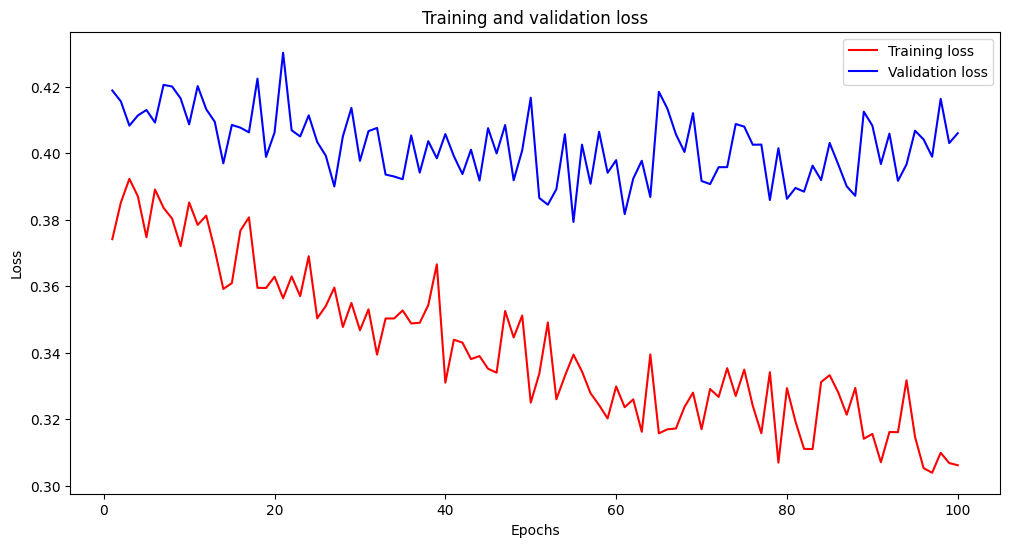

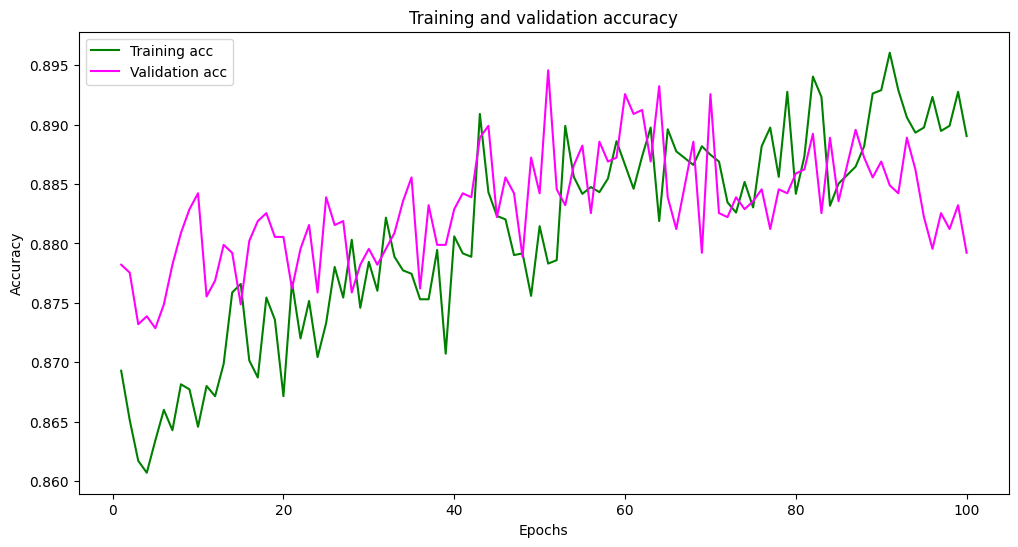

In [ ]:
# Plot the training and validation accuracy and loss at each epoch
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'red', label='Training loss', color='red')  # Red for training loss
plt.plot(epochs, val_loss, 'blue', label='Validation loss', color='blue')  # Blue for validation loss
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 6))
acc = history_lstm.history['accuracy']
val_acc = history_lstm.history['val_accuracy']
plt.plot(epochs, acc, 'green', label='Training acc', color='green')  # Green for training accuracy
plt.plot(epochs, val_acc, 'magenta', label='Validation acc', color='magenta')  # Magenta for validation accuracy
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


## Comparison of CNN and LSTM model

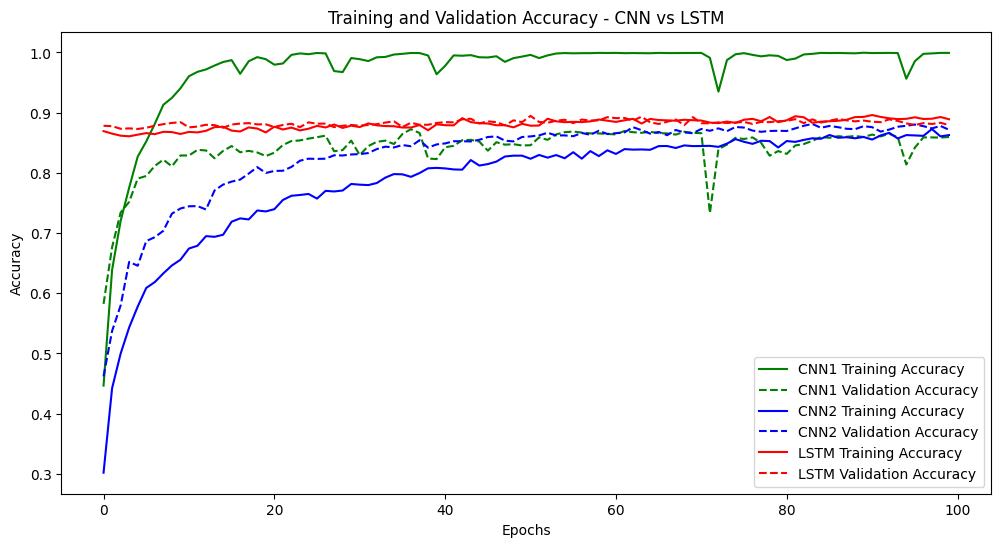

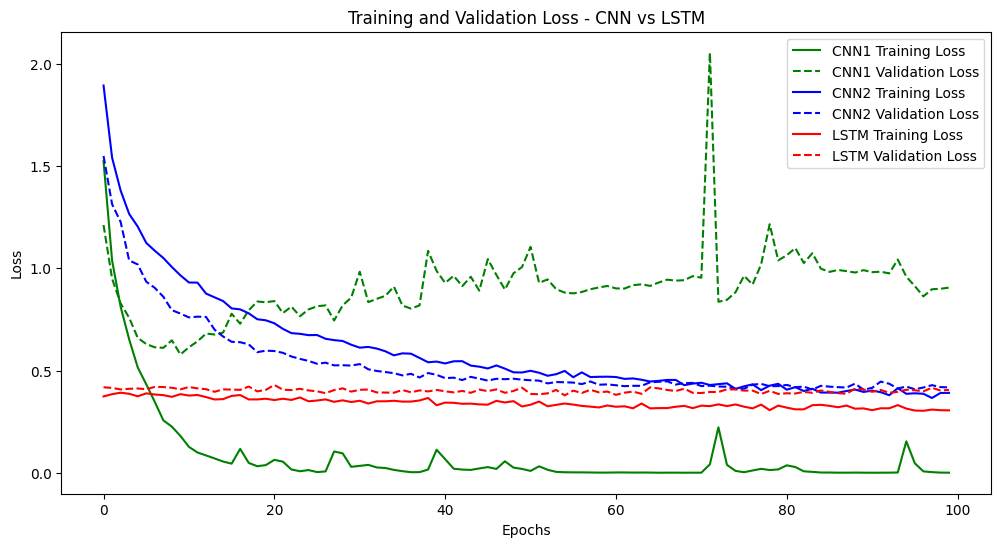

In [ ]:

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_cnn1.history['accuracy'], label='CNN1 Training Accuracy', color='green')
plt.plot(history_cnn1.history['val_accuracy'], label='CNN1 Validation Accuracy', color='green', linestyle='dashed')
plt.plot(history_cnn2.history['accuracy'], label='CNN2 Training Accuracy', color='blue')
plt.plot(history_cnn2.history['val_accuracy'], label='CNN2 Validation Accuracy', color='blue', linestyle='dashed')
plt.plot(history_lstm.history['accuracy'], label='LSTM Training Accuracy', color='red')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Validation Accuracy', color='red', linestyle='dashed')
plt.title('Training and Validation Accuracy - CNN vs LSTM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_cnn1.history['loss'], label='CNN1 Training Loss', color='green')
plt.plot(history_cnn1.history['val_loss'], label='CNN1 Validation Loss', color='green', linestyle='dashed')
plt.plot(history_cnn2.history['loss'], label='CNN2 Training Loss', color='blue')
plt.plot(history_cnn2.history['val_loss'], label='CNN2 Validation Loss', color='blue', linestyle='dashed')
plt.plot(history_lstm.history['loss'], label='LSTM Training Loss', color='red')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss', color='red', linestyle='dashed')
plt.title('Training and Validation Loss - CNN vs LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
